# Efficient Area division and optimal allocation for aerial imaging
**The problem**

A company provides aerial imagery solution to its clients. The clients choose the desired Area of Interest (AoI) through an online platform. Possible coverage solutions are offered for the clients choice, with different pricing, quality, and delivery time.

Computing multiple coverage solutions requires a database of asset performance and availability, and computing asset flight paths to obtain the required endurance for each AoI. This ensures that the imaging mission can be flow by the corresponding asset. 

A flight path calculation algorithm was developped to generate trajectories very quickly. Unfortunately, this algorithm can only operate on "simple shapes", ie. convex areas.

To simplify potentially complex user-input AoIs into simple shapes for which the trajectory calculation algorithm can function, an area division algorithm was developped.

In addition, a simple linear programming optimization model was created to assign these "simple shapes" to separate assets for multi-asset mission solutions. For the purpose of this demonstration, and because the trajectory algorithm is proprietary, this demonstration bypasses the endurance calculation of the trajectory algorithm and substitutes AoI area as the asset performance capacity.

## Generating random AoIs for testing
Let's first develop a function to generate random AoIs that simulate user input. The following function creates a random polygon by creating random points, converting their coordinates from cartesian to polar, sorting the polar coordinates and reconverting back to cartesian.

Next, we will add obstacles to this AoI to simulate potential no-fly zones and other obstacles.
### Generating main AoI

In [4]:
import random
import numpy as np
from shapely.geometry import Polygon

def pol2cart(rho, phi):
    phi=phi/180*np.pi
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(int(x), int(y))

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)/np.pi*180
    return(rho, phi)

def generate_random_polygon(number_of_corners, scale=300):
    # create random points
    corners = []
    for _ in range(number_of_corners):
        corners.append(tuple([random.randint(-scale,scale), random.randint(-scale,scale)]))

    # calculate center of points
    xc = sum([pt[0] for pt in corners])/number_of_corners
    yc = sum([pt[1] for pt in corners])/number_of_corners

    # convert to polar coordinates relative to center
    polar_corners = []
    for pt in corners:
        polar_corners.append(cart2pol(pt[0]-xc, pt[1]- yc))

    # sort by angle in polar coordinates
    sorted_polar_corners = sorted(polar_corners, key=lambda x: x[1])

    # convert back to cartesian
    sorted_corners = []
    for pt in sorted_polar_corners:
        x, y = (pol2cart(pt[0],pt[1]))
        sorted_corners.append((x+xc,y+yc))
        
    return Polygon(sorted_corners), (xc, yc)

### Plotting Polygon objects
Let's make a function to plot these objects and test it.

In [5]:
import matplotlib.pyplot as plt

def plot_poly(poly, fill_color=False):
    # if list of Polygons, plot each one
    if isinstance(poly, (list,)):
        for p in poly:
            x, y = p.exterior.xy
            if fill_color:            
                plt.fill(x, y, edgecolor='black', facecolor=fill_color)
            else:
                plt.fill(x, y, edgecolor='black')
    else:
        x, y = poly.exterior.xy
        if fill_color:            
            plt.fill(x, y, edgecolor='black', facecolor=fill_color)
        else:
            plt.fill(x, y, edgecolor='black')

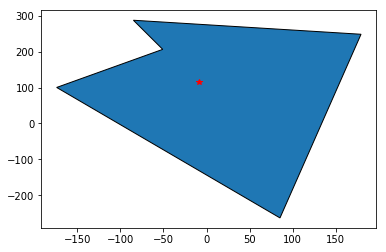

In [20]:
aoi, center = generate_random_polygon(5)
plot_poly(aoi)
plt.plot(center[0],center[1], 'r*')

### Generating obstacles / no fly zones
Now that we have our main AoI, we can add obstacles to it to make it more complex.

In [21]:
# function to make a number of obstacles
def generate_random_obstacles(number_of_obstacles, number_of_corners = 3, scale = 100):
    obstacles = []
    for _ in range(number_of_obstacles):
            obstacles.append(generate_random_polygon(number_of_corners, scale=scale)[0])
    return obstacles

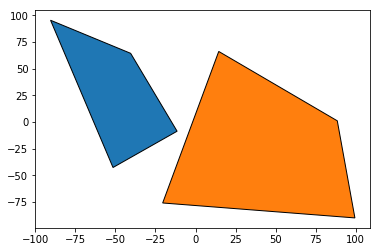

In [25]:
obstacles = generate_random_obstacles(2, 4)
plot_poly(obstacles)

### Combined plot
Let's take a look at both the AoI and the obstacles.

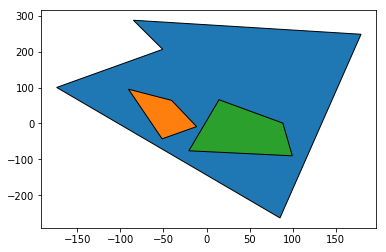

In [26]:
plot_poly(aoi)
plot_poly(obstacles)

## Generating simple shapes from AoI and obstacles
The area shaded in blue above is too complex to be input into the trajectory calculation algorithm. To reduce it to multiple, simpler shapes, a simply heuristic is applied:
* Initiate an empty list of points at which the AoI will be tiled vertically 
* Add every obstacle vertice to the list
* Generate a convex hull of the AoI
* Compare the vertices of the convex hull to the vertices of the original AoI
* Add the pts present in the original AoI but not the convex hull to the list of points 
* The simpler shapes are created by generating a rectangular box between two consecutive tile points, and computing its intersection with the Polygon consisting of the AoI as a positive area and the obstacles as negative area

In [27]:
from shapely.geometry import box, MultiPolygon, GeometryCollection

def generate_tiles(aoi, obstacles):
    aoi_and_obstacles = Polygon(aoi)
    
    x_tilepoints = []
    for obs in obstacles:
#         create a Polygon of the AoI with the obstacle as a hole
        aoi_and_obstacles = aoi_and_obstacles.difference(obs)
        obs_points = set(list(obs.exterior.coords))
#         add each vertice from the obstacles
        for pt in obs_points:
            x_tilepoints.append(pt[0])
            
#   add each pt not in the convex hull to the list of tile points
    aoi_points = set(list(aoi.exterior.coords))
    aoi_convex = aoi.convex_hull
    hull_points = set(list(aoi_convex.exterior.coords))
    to_add = [pt[0] for pt in list(aoi_points-hull_points)]
    x_tilepoints.extend(to_add)
    
#     add the x boundaries of the aoi to the tile points list
    bounds = aoi.bounds
    x_tilepoints = sorted(set(x_tilepoints))
    x_tilepoints.append(bounds[2])
    
    
    tiles = []
#     loop through the tilepoints and create a box between each consecutive one
    for i, x in enumerate(x_tilepoints):
        if i == 0:
            tile = box(bounds[0], bounds[1], x, bounds[3])
        else:
            tile = box(x_tilepoints[i - 1], bounds[1], x, bounds[3])
#   compute the intersection between the tile and the aoi and obstacles
        tiled_poly = aoi_and_obstacles.intersection(tile)

#  if multiple tiles are created,add each to the output
        if isinstance(tiled_poly, (MultiPolygon, GeometryCollection)):
            tiled_poly = list(tiled_poly)
            tiles.extend([p for p in tiled_poly if isinstance(p, Polygon)])
        else:
            tiles.append(tiled_poly)
    return tiles

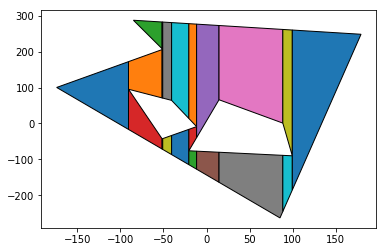

In [28]:
tiles = generate_tiles(aoi, obstacles)
plot_poly(tiles)

### Dividing tiles by area threshold
In the case where it is desirable to limit the size of the tiles, either for trajectory computation efficiency or maximum single asset capacity, the tiles can be further split into halves if they are above the chosen area threshold.

In [29]:
def divide_tile(tile):
    bounds = tile.bounds
    width = bounds[2] - bounds[0]
    height = bounds[3] - bounds[1]
#     if height bigger, divide horizontally
    if height >= width:
        tile_top = box(bounds[0], bounds[1], bounds[2], bounds[1] + height / 2)
        tile_bottom = box(bounds[0], bounds[1] + height / 2, bounds[2], bounds[3])
        list_split_tile = [tile.intersection(tile_top), tile.intersection(tile_bottom)]
#       if width bigger, divide vertically
    else:
        tile_left = box(bounds[0], bounds[1], bounds[0] + width / 2, bounds[3])
        tile_right = box(bounds[0] + width / 2, bounds[1], bounds[2], bounds[3])
        list_split_tile = [tile.intersection(tile_left), tile.intersection(tile_right)]
    return list_split_tile


def reduce_large_tiles(tiles, threshold):
    new_tiles = []
    for tile in tiles:
#         recursively divide tiles until none are above the input threshold
        if tile.area <= threshold:
            new_tiles.append(tile)
        else:
            subtile_list = divide_tile(tile)
            new_tiles.extend(reduce_large_tiles(subtile_list, threshold))
    return [tile for tile in new_tiles if isinstance(tile, (Polygon, ))]

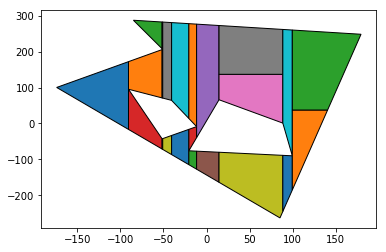

In [30]:
reduced_tiles = reduce_large_tiles(tiles, 15000)
plot_poly(reduced_tiles)

We have succesfully reduced our complex AoI and obstacles into a set of simpler shapes for which the trajectory computation can be performed efficiently.

## Allocating tiles optimally for multi-asset missions
In the case where the total AoI endurance required exceeds the single capacity of one asset, it is desirable to allocate the various tiles to different assets optimally. The goal is to either
* Minimize the number of assets used
* maximize the contiguity of the tiles assigned

To maximize the contiguity of the tiles assigned, the number of vertices in common between each is a better metric than the distance between their centroids.
### Parameter calculations and inputs
Calculating the vertices in common between tiles is easy. The areas can also be calculated as a subsitute for the trajectory/endurance algorithm.

In [31]:
def calc_pts_in_common(tiles):
    # loop through each tile and calculate the pts in common with every other tile
    pts_in_common = {}
    for i, tile in enumerate(tiles):
        pts_in_common[i] = {}
        tile_points_list = list(tile.exterior.coords)
        for j, tile_2 in enumerate(tiles):
            tile_points_list_2 = list(tile_2.exterior.coords)
            if i == j:
                pts_in_common[i][j] = 0
            else:
                pts_in_common[i][j] = sum([pt in tile_points_list for pt in tile_points_list_2])
    return pts_in_common

def calc_params(tiles):
    tile_areas = [tile.area for tile in tiles]
    pts_in_common = calc_pts_in_common(tiles)
    return tile_areas, pts_in_common
    
tile_areas, pts_in_common = calc_params(reduced_tiles)

### Linear Programming allocation model
This simple model allocates a tile to a single asset, while enforcing that each asset does not exceed its capacity, and trying to maximize the contiguity of the cells assigned to a same asset. It uses two main variable sets:

* x(a,c,cc): corresponds to the assignement of asset a to cells c and cc
* y(a): corresponds to the usage of the asset a

For creating the model and running the solver, we use the pulp python module.

In [32]:
import pulp as plp

def build_model(asset_area_capacities, tile_areas, pts_in_common, model_number=''):
    
    n_assets = len(asset_area_capacities)
    n_cells = len(tile_areas)
    
    opt_model = None
    opt_model = plp.LpProblem(name="Area Allocation"+model_number)

    # variables
#     variable tracking the usage of each asset
    y = {(a): plp.LpVariable(cat=plp.LpBinary, name="asset_used_{0}".format(a))
                             for a in range(n_assets)}
    
# variable tracking the assignment PAIRS for each cell, for each cell, for each asset
    x  = {(a,c,cc): plp.LpVariable(cat=plp.LpBinary, name="asset_cell_{0}_{1}_{2}".format(a,c,cc))
                             for a in range(n_assets) for c in range(n_cells) for cc in range(c, n_cells)}

    # constraints
    # capacity constraint on each asset: the sum of cells assigned multiplied by their area must be below the asset cap
    for a in range(n_assets):
        opt_model += plp.lpSum(x[a,c,c]*tile_areas[c] for c in range(n_cells)) <= asset_area_capacities[a] , "asset_capacity_{0}".format(a)

    # each cell must be assigned once and only once: the sum of each variable accross all assets must be 1     
    for c in range(n_cells):
        opt_model += plp.lpSum(x[a,c,c] for a in range(n_assets)) == 1 , "cell_assignment_tracking_{0}".format(c)

        
    # the variables tracking cells assigned together same asset must reflect the "diagonal" variables tracking cell assignment
    for a in range(n_assets):
        for c in range(n_cells):
            for cc in range(c, n_cells):
                opt_model += (x[a,c,cc] >= x[a,c,c] + x[a,cc,cc] -1,
                "cell_combination_tracking_A{}_{}_{}".format(a,c,cc))

                opt_model += (x[a,c,cc] <= (x[a,c,c] + x[a,cc,cc])/2,
                "cell_combination_tracking_B{}_{}_{}".format(a,c,cc))

    # track asset useage: the variable must take value 1 if any 
    for a in range(n_assets):
        for c in range(n_cells):
            for cc in range(c, n_cells):
                opt_model += (y[a] >= x[a,c,cc],
                "asset_useage_tracking_{0}_{1}_{2}".format(a,c,cc))            

#     minimize
    objective = plp.lpSum(y[a]*100 for a in range(n_assets))
    objective += plp.lpSum(-x[a,c,cc]*pts_in_common[c][cc] for a in range(n_assets) for c in range(n_cells) for cc in range(c, n_cells))
    opt_model.sense = plp.LpMinimize
    opt_model.setObjective(objective)
    
#     opt_model.writeLP("area_allocation.lp")

    
    return opt_model

def solve_model(model):
    model.solve()
    print("Model {} status: {}".format(model.name, plp.LpStatus[model.status]))
    solution = {}
    for var in model.variables():
        solution[var.name] = var.value()
    return solution

### Running the model
All that's left is inputting some arbitrary asset capacities and solving the model.

In [33]:
asset_area_capacities = [30000, 40000, 50000, 60000]
model = build_model(asset_area_capacities, tile_areas, pts_in_common)
solution = solve_model(model)

Model Area Allocation status: Optimal


### Visualizing solution
We can plot all the cells assigned to the same asset with a specific color.

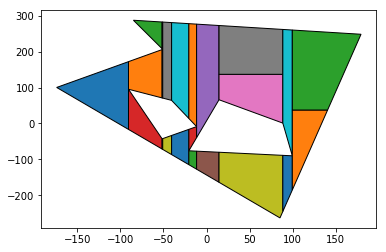

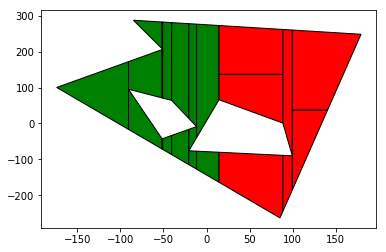

In [34]:
from matplotlib import colors as mcolors

def plot_solution(solution, n_assets, tiles):
    # get a list of all the colors so we never run out
    colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
    colors = list(colors.keys())
    for a in range(n_assets):
        for c in range(len(tiles)):
            if solution["asset_cell_{0}_{1}_{2}".format(a,c,c)] == 1:
                plot_poly(tiles[c], fill_color=colors[a])
    

plot_poly(reduced_tiles)
plt.figure()
plot_solution(solution, len(asset_area_capacities), reduced_tiles)

### Reading the solution
Let's also print a read out of the totals assigned to each asset.

In [35]:
def read_solution(solution, asset_area_capacities, tile_areas):
    for a in range(len(asset_area_capacities)):
        running_total = 0
        if solution["asset_used_{0}".format(a)] == 1:
            print('Asset {} used.'.format(a))
            for c in range(len(tile_areas)):
                if solution["asset_cell_{0}_{1}_{2}".format(a,c,c)] == 1:
                    area = round(tile_areas[c],1)
                    print('  Covering cell {}, area {}'.format(c, area))
                    running_total += area
            print('  Total usage: {}/{}'.format(round(running_total,1), asset_area_capacities[a]))
        else:
            print('Asset {} not used.'.format(a))

read_solution(solution, asset_area_capacities, tile_areas)

Asset 0 not used.
Asset 1 used.
  Covering cell 0, area 7852.5
  Covering cell 1, area 4119.6
  Covering cell 2, area 1239.0
  Covering cell 3, area 2735.0
  Covering cell 4, area 94.5
  Covering cell 5, area 52.6
  Covering cell 6, area 20.5
  Covering cell 7, area 2203.9
  Covering cell 8, area 428.8
  Covering cell 9, area 4802.0
  Covering cell 10, area 1514.8
  Covering cell 11, area 2470.1
  Covering cell 12, area 399.9
  Covering cell 13, area 406.5
  Covering cell 14, area 6791.0
  Covering cell 15, area 1740.0
  Total usage: 36870.7/40000
Asset 2 used.
  Covering cell 16, area 7641.6
  Covering cell 17, area 9642.2
  Covering cell 18, area 9669.2
  Covering cell 19, area 3358.1
  Covering cell 20, area 1381.6
  Covering cell 21, area 4554.2
  Covering cell 22, area 13180.5
  Total usage: 49427.4/50000
Asset 3 not used.


The minimal number of assets is used, and their allocation maximizes contiguity!

## Algorithm testing
With the full algorithm ready, let's test it on different randomly generated inputs.

Testing on random AoI with 5 corners, 0 obstacles, 3 obstacle corners.
Model Area Allocation0 status: Optimal
Asset 0 not used.
Asset 1 not used.
Asset 2 not used.
Asset 3 used.
  Covering cell 0, area 8809.0
  Covering cell 1, area 9382.7
  Covering cell 2, area 8332.1
  Covering cell 3, area 8311.7
  Total usage: 34835.5/60000


Testing on random AoI with 4 corners, 1 obstacles, 3 obstacle corners.
Model Area Allocation1 status: Optimal
Asset 0 not used.
Asset 1 not used.
Asset 2 not used.
Asset 3 used.
  Covering cell 0, area 4358.2
  Covering cell 1, area 13074.6
  Covering cell 2, area 10323.4
  Covering cell 3, area 8507.8
  Covering cell 4, area 9732.5
  Total usage: 45996.5/60000


Testing on random AoI with 6 corners, 0 obstacles, 5 obstacle corners.
Model Area Allocation2 status: Optimal
Asset 0 not used.
Asset 1 not used.
Asset 2 used.
  Covering cell 4, area 9719.2
  Covering cell 5, area 14148.5
  Covering cell 6, area 14106.4
  Covering cell 7, area 1433.6
  Total usage: 

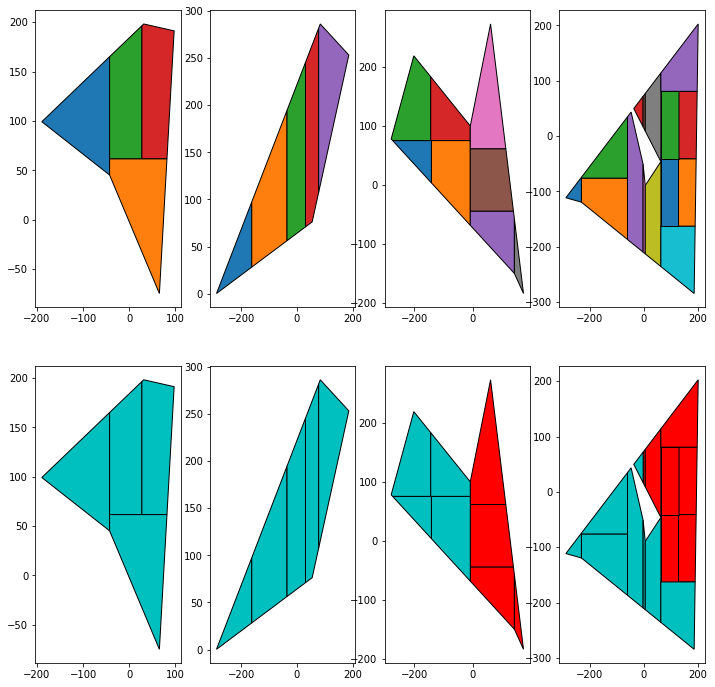

In [36]:
def test_algorithm(n_tests, asset_area_capacities):
    plt.figure(figsize=(12,12))
    for x in range(n_tests):
        number_of_corners_aoi = random.randint(4,6)
        aoi, center = generate_random_polygon(number_of_corners_aoi)
        
        number_of_obstacles = random.randint(0,2)
        number_of_corners_obstacles = random.randint(3,5) 
        print('Testing on random AoI with {} corners, {} obstacles, {} obstacle corners.'.format(number_of_corners_aoi,
                                                                                                number_of_obstacles,
                                                                                                number_of_corners_obstacles))
        obstacles = generate_random_obstacles(number_of_obstacles, number_of_corners_obstacles)
        
        tiles = generate_tiles(aoi, obstacles)
        reduced_tiles = reduce_large_tiles(tiles, 15000)
                
        tile_areas, pts_in_common = calc_params(reduced_tiles)
        
        model = build_model(asset_area_capacities, tile_areas, pts_in_common, model_number=str(x))
        
        solution = solve_model(model)
        
        plt.subplot(2, n_tests, 1 + x)
        plot_poly(reduced_tiles)
        plt.subplot(2, n_tests, 1 + n_tests+ x)
        plot_solution(solution, len(asset_area_capacities), reduced_tiles)
        read_solution(solution, asset_area_capacities, tile_areas)
        print('\n')
        
asset_area_capacities = [30000, 40000, 50000, 60000]
test_algorithm(4, asset_area_capacities)      

Results look good. The minimal number of assets is used, and the contiguity is maximized for their cell allocation.
## Conclusion
Using this algorithm, we were able to transform complex shapes for which no trajectory/endurance calculation can be performed into multiple simpler shapes for which the trajectory/endurance calculation can take place. Using a simple integer program, we were able to assign each of these subdivisions to assets according to their capacity, while maximizing contiguity of the cells assigned.